# Практическая работа №5

## Тема: Реализация параллельных структур данных на GPU

### Практическая часть
Часть 1. Реализация параллельного стека на CUDA

Задание: Реализовать структуру данных стек с использованием атомарных
операций для безопасного доступа к данным.

Задачи:
1. Инициализировать стек с фиксированной емкостью.
2. Написать ядро CUDA, использующее push и pop параллельно из
нескольких потоков.
3. Проверить корректность выполнения операций.

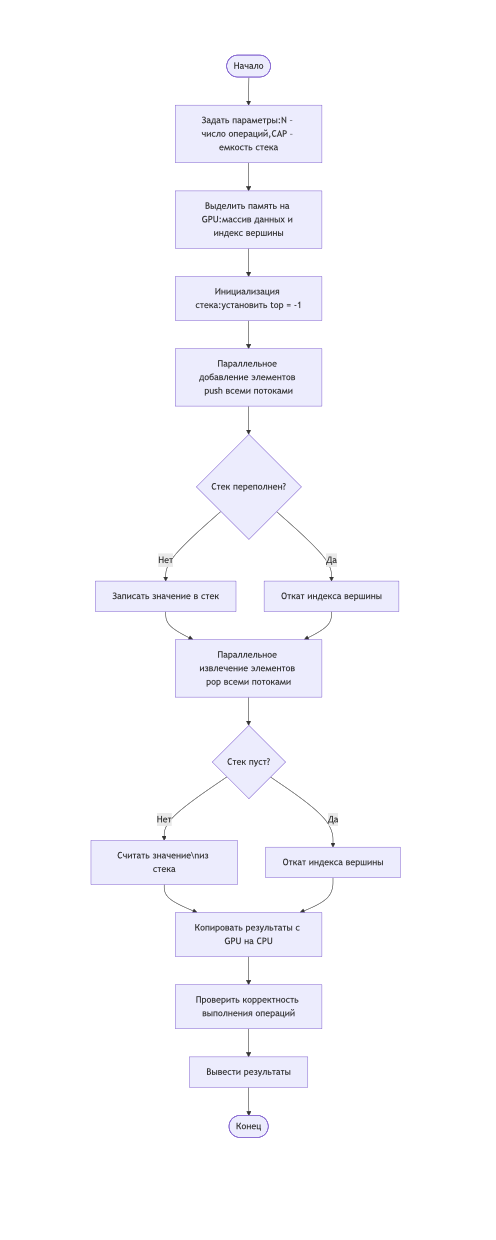


In [7]:
!nvidia-smi

Mon Jan  5 10:05:06 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
%%writefile stack_lab1.cu

#include <cuda_runtime.h>
#include <iostream>
#include <vector>
#include <algorithm>

// Макрос для проверки ошибок CUDA
#define CUDA_OK(call) do { \
    cudaError_t e = (call); \
    if (e != cudaSuccess) { \
        std::cerr << "CUDA error: " << cudaGetErrorString(e) \
                  << " at line " << __LINE__ << std::endl; \
        exit(1); \
    } \
} while(0)

// ---------------------- СТРУКТУРА СТЕКА ----------------------
struct Stack {
    int* data;        // Указатель на массив данных в глобальной памяти GPU
    int* top;         // Указатель на индекс вершины стека в глобальной памяти
    int capacity;     // Максимальная емкость стека

    // Инициализация стека
    __device__ void init(int* buffer, int* topPtr, int size) {
        data = buffer;        // Привязываем массив данных
        top = topPtr;         // Привязываем указатель на вершину
        capacity = size;      // Задаем емкость

        // Только один поток инициализирует вершину
        if (blockIdx.x == 0 && threadIdx.x == 0) {
            *top = -1;        // Стек пуст
        }
    }

    // Операция push (добавление элемента)
    __device__ bool push(int value) {
        // Атомарно увеличиваем вершину и получаем новый индекс
        int newTop = atomicAdd(top, 1) + 1;

        // Проверяем, что не вышли за пределы стека
        if (newTop < capacity) {
            data[newTop] = value; // Записываем значение
            return true;          // Успешно
        }

        // Если переполнение — откатываем индекс
        atomicSub(top, 1);
        return false;             // Ошибка push
    }

    // Операция pop (извлечение элемента)
    __device__ bool pop(int* value) {
        // Атомарно уменьшаем вершину и получаем старое значение
        int oldTop = atomicSub(top, 1);

        // Проверяем, что стек не пуст
        if (oldTop >= 0) {
            *value = data[oldTop]; // Считываем значение
            return true;           // Успешно
        }

        // Если стек пуст — откатываем индекс
        atomicAdd(top, 1);
        return false;              // Ошибка pop
    }
};

// ---------------------- CUDA ЯДРА ----------------------

// Ядро инициализации стека
__global__ void initKernel(Stack s, int* buffer, int* topPtr, int cap) {
    s.init(buffer, topPtr, cap);   // Вызываем init на GPU
}

// Ядро параллельного push
__global__ void pushKernel(Stack s, int N, int* push_ok) {
    // Получаем глобальный идентификатор потока
    int tid = blockIdx.x * blockDim.x + threadIdx.x;

    // Проверяем, что поток в пределах N
    if (tid < N) {
        // Каждый поток кладет свое значение
        if (s.push(tid)) {
            atomicAdd(push_ok, 1); // Считаем успешные push
        }
    }
}

// Ядро параллельного pop
__global__ void popKernel(Stack s, int N, int* out, int* pop_ok) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;

    if (tid < N) {
        int val = -1;              // Значение по умолчанию
        bool ok = s.pop(&val);     // Пытаемся извлечь элемент
        out[tid] = ok ? val : -1;  // Записываем результат
        if (ok) atomicAdd(pop_ok, 1); // Считаем успешные pop
    }
}

// ---------------------- ПРОВЕРКА КОРРЕКТНОСТИ ----------------------
bool check_set(const std::vector<int>& out, int N) {
    std::vector<int> v = out; // Копируем выходной массив

    // Удаляем элементы со значением -1
    v.erase(std::remove(v.begin(), v.end(), -1), v.end());

    // Проверяем количество элементов
    if ((int)v.size() != N) return false;

    // Сортируем элементы
    std::sort(v.begin(), v.end());

    // Проверяем, что есть все значения от 0 до N-1
    for (int i = 0; i < N; i++) {
        if (v[i] != i) return false;
    }
    return true;
}

// ---------------------- MAIN ----------------------
int main() {
    int N = 1024;              // Количество потоков / операций
    int CAP = N;               // Фиксированная емкость стека
    int block = 256;           // Размер блока
    int grid = (N + block - 1) / block; // Количество блоков

    // Указатели на память GPU
    int *d_data, *d_top, *d_out;
    int *d_push_ok, *d_pop_ok;

    // Выделяем память на GPU
    CUDA_OK(cudaMalloc(&d_data, CAP * sizeof(int)));
    CUDA_OK(cudaMalloc(&d_top, sizeof(int)));
    CUDA_OK(cudaMalloc(&d_out, N * sizeof(int)));
    CUDA_OK(cudaMalloc(&d_push_ok, sizeof(int)));
    CUDA_OK(cudaMalloc(&d_pop_ok, sizeof(int)));

    // Обнуляем счетчики
    CUDA_OK(cudaMemset(d_push_ok, 0, sizeof(int)));
    CUDA_OK(cudaMemset(d_pop_ok, 0, sizeof(int)));

    // Создаем объект стека
    Stack s{d_data, d_top, CAP};

    // Инициализация стека
    initKernel<<<1,1>>>(s, d_data, d_top, CAP);
    CUDA_OK(cudaDeviceSynchronize());

    // Параллельные push
    pushKernel<<<grid, block>>>(s, N, d_push_ok);
    CUDA_OK(cudaDeviceSynchronize());

    // Параллельные pop
    popKernel<<<grid, block>>>(s, N, d_out, d_pop_ok);
    CUDA_OK(cudaDeviceSynchronize());

    // Копируем счетчики на CPU
    int push_ok = 0, pop_ok = 0;
    CUDA_OK(cudaMemcpy(&push_ok, d_push_ok, sizeof(int), cudaMemcpyDeviceToHost));
    CUDA_OK(cudaMemcpy(&pop_ok, d_pop_ok, sizeof(int), cudaMemcpyDeviceToHost));

    // Копируем результат pop
    std::vector<int> out(N);
    CUDA_OK(cudaMemcpy(out.data(), d_out, N * sizeof(int), cudaMemcpyDeviceToHost));

    // Проверяем корректность
    bool correct = (push_ok == N) && (pop_ok == N) && check_set(out, N);

    // Выводим результаты
    std::cout << "push_ok = " << push_ok << " / " << N << std::endl;
    std::cout << "pop_ok  = " << pop_ok  << " / " << N << std::endl;
    std::cout << "Correct = " << (correct ? "YES" : "NO") << std::endl;

    std::cout << "First 10 popped values:\n";
    for (int i = 0; i < 10; i++) std::cout << out[i] << " ";
    std::cout << std::endl;

    // Освобождаем память GPU
    cudaFree(d_data);
    cudaFree(d_top);
    cudaFree(d_out);
    cudaFree(d_push_ok);
    cudaFree(d_pop_ok);

    return 0; // Завершение программы
}


Overwriting stack_lab1.cu


In [18]:
!nvcc stack_lab1.cu -O2 -std=c++17 -gencode arch=compute_75,code=sm_75 -o stack_lab1
!./stack_lab1


push_ok = 1024 / 1024
pop_ok  = 1024 / 1024
Correct = YES
First 10 popped values:
703 702 701 700 699 698 697 696 695 694 


Часть 2. Реализация параллельной очереди на CUDA

Задание: Реализовать очередь с использованием атомарных операций для
безопасного добавления и удаления элементов.

Задачи:
1. Инициализировать очередь с заданной емкостью.
2. Написать ядро CUDA, использующее enqueue и dequeue параллельно.
3. Сравнить производительность очереди и стека.

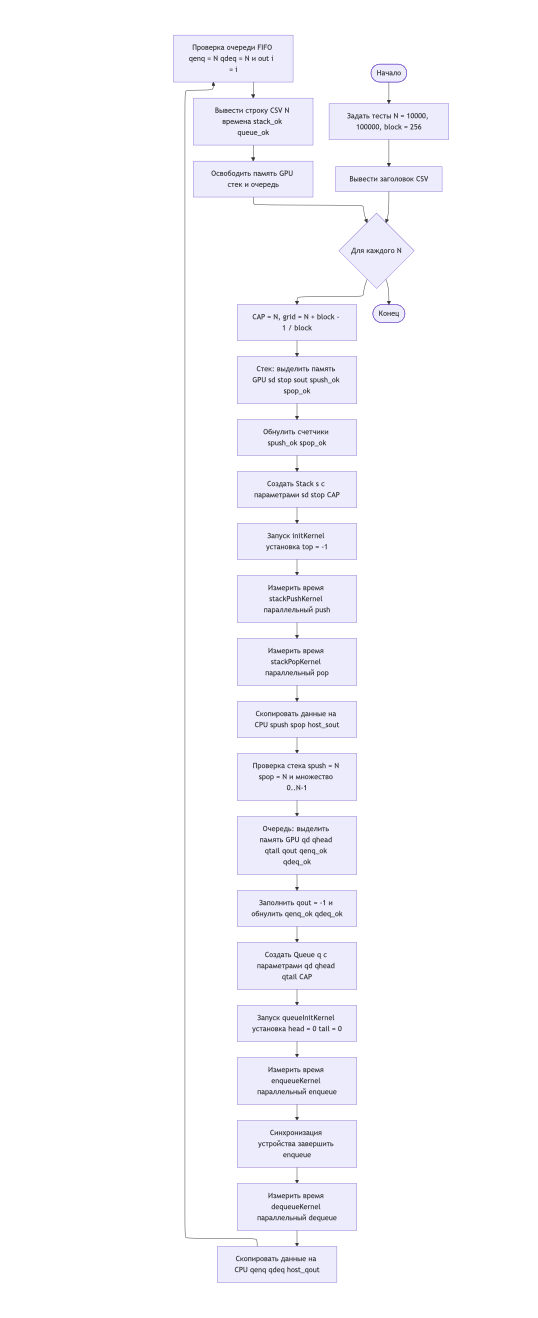

In [36]:
%%writefile stack_queue_bench.cu
// bench_stack_queue.cu
#include <cuda_runtime.h>   // CUDA Runtime API (cudaMalloc, cudaMemcpy, cudaEvent и т.д.)
#include <iostream>         // вывод в консоль
#include <vector>           // удобный динамический массив на CPU
#include <algorithm>        // sort, remove
#include <functional>       // std::function для таймера

// проверка ошибок CUDA (если ошибка — печатаем и завершаем программу)
#define CUDA_OK(call) do { \
  cudaError_t e = (call); \
  if (e != cudaSuccess) { \
    std::cerr << "CUDA error: " << cudaGetErrorString(e) \
              << " at line " << __LINE__ << "\n"; \
    std::exit(1); \
  } \
} while(0)


// =============================================================
// 1) ПАРАЛЛЕЛЬНЫЙ СТЕК (LIFO)
// =============================================================
struct Stack {
    int* data;       // массив данных в глобальной памяти GPU
    int* top;        // общий индекс вершины стека (в глобальной памяти GPU)
    int  capacity;   // максимальная емкость

    // Инициализация стека на GPU
    __device__ void init(int* buffer, int* topPtr, int size) {
        data = buffer;          // привязали массив данных
        top  = topPtr;          // привязали общий top
        capacity = size;        // задали емкость

        // Инициализируем top только одним потоком
        if (blockIdx.x == 0 && threadIdx.x == 0) *top = -1; // -1 значит "пусто"
    }

    // push: добавить элемент (с атомарной защитой)
    __device__ bool push(int value) {
        // atomicAdd безопасно увеличивает top при параллельных потоках
        int newTop = atomicAdd(top, 1) + 1;  // новый индекс вершины

        // если не переполнили стек — записываем
        if (newTop < capacity) {
            data[newTop] = value;
            return true;
        }

        // если переполнили — откатываем top назад
        atomicSub(top, 1);
        return false;
    }

    // pop: извлечь элемент (с атомарной защитой)
    __device__ bool pop(int* value) {
        // atomicSub безопасно уменьшает top
        int oldTop = atomicSub(top, 1); // oldTop = top до уменьшения

        // если стек не пуст — читаем элемент
        if (oldTop >= 0) {
            *value = data[oldTop];
            return true;
        }

        // если стек был пуст — откатываем top
        atomicAdd(top, 1);
        return false;
    }
};

// Ядро инициализации стека
__global__ void stackInitKernel(Stack s, int* buffer, int* topPtr, int cap) {
    s.init(buffer, topPtr, cap);
}

// Ядро: параллельный push (каждый поток кладёт tid)
__global__ void stackPushKernel(Stack s, int N, int* ok) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x; // глобальный id потока
    if (tid < N) {
        if (s.push(tid)) atomicAdd(ok, 1); // считаем успешные операции
    }
}

// Ядро: параллельный pop (каждый поток пытается достать элемент)
__global__ void stackPopKernel(Stack s, int N, int* out, int* ok) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    if (tid < N) {
        int val = -1;                 // значение по умолчанию
        bool r = s.pop(&val);         // пытаемся извлечь
        out[tid] = r ? val : -1;      // сохраняем результат
        if (r) atomicAdd(ok, 1);      // считаем успешные pop
    }
}


// =============================================================
// 2) ПАРАЛЛЕЛЬНАЯ ОЧЕРЕДЬ (FIFO)
// =============================================================
// 1) enqueue (все добавили)
// 2) synchronize
// 3) dequeue (все извлекли)
// - enqueue записывает data[pos] = pos
// - dequeue возвращает pos, и мы записываем out[pos] = value
struct Queue {
    int* data;       // массив данных в глобальной памяти GPU
    int* head;       // индекс "головы" (откуда читаем)
    int* tail;       // индекс "хвоста" (куда пишем)
    int  capacity;   // емкость

    // Инициализация очереди
    __device__ void init(int* buffer, int* headPtr, int* tailPtr, int size) {
        data = buffer;
        head = headPtr;
        tail = tailPtr;
        capacity = size;

        // Инициализируем head/tail одним потоком
        if (blockIdx.x == 0 && threadIdx.x == 0) {
            *head = 0;
            *tail = 0;
        }
    }

    // enqueue: добавить элемент в хвост
    __device__ bool enqueue(int /*value*/) {
        // atomicAdd выделяет уникальную позицию для каждого потока
        int pos = atomicAdd(tail, 1);

        // если есть место — записываем
        if (pos < capacity) {
            data[pos] = pos;   // кладём pos, чтобы на выходе было 0..N-1
            return true;
        }

        // если переполнение — откатываем tail
        atomicSub(tail, 1);
        return false;
    }

    // dequeue: извлечь элемент из головы
    __device__ bool dequeue(int* value, int* outPos) {
        // atomicAdd безопасно увеличивает head
        int pos = atomicAdd(head, 1);

        // tail уже сформирован, т.к. enqueue завершили (2-фазный запуск)
        int t = *tail;

        // если head < tail — можно читать
        if (pos < t) {
            *value = data[pos];   // читаем значение
            *outPos = pos;        // сохраняем позицию (для записи out[pos])
            return true;
        }

        // если пусто — откатываем head
        atomicSub(head, 1);
        return false;
    }
};

// Ядро инициализации очереди
__global__ void queueInitKernel(Queue q, int* buffer, int* headPtr, int* tailPtr, int cap) {
    q.init(buffer, headPtr, tailPtr, cap);
}

// Ядро: параллельный enqueue
__global__ void enqueueKernel(Queue q, int N, int* ok) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    if (tid < N) {
        if (q.enqueue(tid)) atomicAdd(ok, 1);
    }
}

// Ядро: параллельный dequeue
__global__ void dequeueKernel(Queue q, int N, int* out, int* ok) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    if (tid < N) {
        int val = -1;
        int pos = -1;

        bool r = q.dequeue(&val, &pos);

        // пишем out[pos], а не out[tid]
        // чтобы out[0] был первым элементом, out[1] — вторым и т.д.
        if (r) {
            out[pos] = val;
            atomicAdd(ok, 1);
        }
    }
}


// =============================================================
// 3) ИЗМЕРЕНИЕ ВРЕМЕНИ (CUDA events)
// =============================================================
float timeKernelMs(const std::function<void()>& launch) {
    cudaEvent_t start, stop;                 // события CUDA
    CUDA_OK(cudaEventCreate(&start));        // создаём start
    CUDA_OK(cudaEventCreate(&stop));         // создаём stop
    CUDA_OK(cudaEventRecord(start));         // старт таймера
    launch();                                // запускаем ядро
    CUDA_OK(cudaEventRecord(stop));          // стоп таймера
    CUDA_OK(cudaEventSynchronize(stop));     // ждём окончания
    float ms = 0.0f;
    CUDA_OK(cudaEventElapsedTime(&ms, start, stop)); // считаем миллисекунды
    CUDA_OK(cudaEventDestroy(start));        // освобождаем события
    CUDA_OK(cudaEventDestroy(stop));
    return ms;
}


// =============================================================
// 4) ПРОВЕРКА КОРРЕКТНОСТИ
// =============================================================

// Для стека порядок не важен: проверяем, что есть все числа 0..N-1
bool check_set_stack(std::vector<int> out, int N) {
    out.erase(std::remove(out.begin(), out.end(), -1), out.end()); // убираем неуспешные pop
    if ((int)out.size() != N) return false;                        // должно быть N значений
    std::sort(out.begin(), out.end());                             // сортируем
    for (int i = 0; i < N; i++) if (out[i] != i) return false;     // сравниваем с 0..N-1
    return true;
}

// Для очереди FIFO: out[i] должно быть равно i
bool check_fifo_queue(const std::vector<int>& out, int N) {
    for (int i = 0; i < N; i++) if (out[i] != i) return false;
    return true;
}


// =============================================================
// 5) MAIN: запуск тестов и сравнение
// =============================================================
int main() {
    std::vector<int> tests = {10000, 100000}; // размеры тестов (как в задании)
    int block = 256;                          // число потоков в блоке

    // заголовок CSV-таблицы
    std::cout << "N,stack_push_ms,stack_pop_ms,stack_ok,queue_enq_ms,queue_deq_ms,queue_ok\n";

    // прогоняем тесты для каждого N
    for (int N : tests) {
        int CAP = N;                              // емкость равна N
        int grid = (N + block - 1) / block;       // число блоков

        // ===================== STACK =====================
        int *sd=nullptr, *stop=nullptr, *sout=nullptr, *spush_ok=nullptr, *spop_ok=nullptr;

        // выделяем память на GPU для стека
        CUDA_OK(cudaMalloc(&sd, CAP * sizeof(int)));
        CUDA_OK(cudaMalloc(&stop, sizeof(int)));
        CUDA_OK(cudaMalloc(&sout, N * sizeof(int)));
        CUDA_OK(cudaMalloc(&spush_ok, sizeof(int)));
        CUDA_OK(cudaMalloc(&spop_ok, sizeof(int)));

        // обнуляем счетчики успешных операций
        CUDA_OK(cudaMemset(spush_ok, 0, sizeof(int)));
        CUDA_OK(cudaMemset(spop_ok, 0, sizeof(int)));

        // создаём объект стека
        Stack s{sd, stop, CAP};

        // инициализация top = -1
        stackInitKernel<<<1,1>>>(s, sd, stop, CAP);
        CUDA_OK(cudaDeviceSynchronize()); // ждём завершения

        // измеряем время push
        float stack_push_ms = timeKernelMs([&](){
            stackPushKernel<<<grid, block>>>(s, N, spush_ok);
        });
        CUDA_OK(cudaDeviceSynchronize());

        // измеряем время pop
        float stack_pop_ms = timeKernelMs([&](){
            stackPopKernel<<<grid, block>>>(s, N, sout, spop_ok);
        });
        CUDA_OK(cudaDeviceSynchronize());

        // копируем счетчики в CPU
        int spush=0, spop=0;
        CUDA_OK(cudaMemcpy(&spush, spush_ok, sizeof(int), cudaMemcpyDeviceToHost));
        CUDA_OK(cudaMemcpy(&spop, spop_ok, sizeof(int), cudaMemcpyDeviceToHost));

        // копируем результаты pop в CPU
        std::vector<int> host_sout(N);
        CUDA_OK(cudaMemcpy(host_sout.data(), sout, N*sizeof(int), cudaMemcpyDeviceToHost));

        // проверяем корректность стека
        bool stack_ok = (spush == N) && (spop == N) && check_set_stack(host_sout, N);

        // ===================== QUEUE =====================
        int *qd=nullptr, *qhead=nullptr, *qtail=nullptr, *qout=nullptr, *qenq_ok=nullptr, *qdeq_ok=nullptr;

        // выделяем память на GPU для очереди
        CUDA_OK(cudaMalloc(&qd, CAP * sizeof(int)));
        CUDA_OK(cudaMalloc(&qhead, sizeof(int)));
        CUDA_OK(cudaMalloc(&qtail, sizeof(int)));
        CUDA_OK(cudaMalloc(&qout, N * sizeof(int)));
        CUDA_OK(cudaMalloc(&qenq_ok, sizeof(int)));
        CUDA_OK(cudaMalloc(&qdeq_ok, sizeof(int)));

        // заполняем qout значением -1 (0xFF -> -1), чтобы видеть, если не записалось
        CUDA_OK(cudaMemset(qout, 0xFF, N * sizeof(int)));

        // обнуляем счетчики
        CUDA_OK(cudaMemset(qenq_ok, 0, sizeof(int)));
        CUDA_OK(cudaMemset(qdeq_ok, 0, sizeof(int)));

        // создаём объект очереди
        Queue q{qd, qhead, qtail, CAP};

        // инициализация head=0, tail=0
        queueInitKernel<<<1,1>>>(q, qd, qhead, qtail, CAP);
        CUDA_OK(cudaDeviceSynchronize());

        // измеряем enqueue
        float queue_enq_ms = timeKernelMs([&](){
            enqueueKernel<<<grid, block>>>(q, N, qenq_ok);
        });
        CUDA_OK(cudaDeviceSynchronize()); // важно: завершить enqueue перед dequeue (2 фазы)

        // измеряем dequeue
        float queue_deq_ms = timeKernelMs([&](){
            dequeueKernel<<<grid, block>>>(q, N, qout, qdeq_ok);
        });
        CUDA_OK(cudaDeviceSynchronize());

        // копируем счетчики в CPU
        int qenq=0, qdeq=0;
        CUDA_OK(cudaMemcpy(&qenq, qenq_ok, sizeof(int), cudaMemcpyDeviceToHost));
        CUDA_OK(cudaMemcpy(&qdeq, qdeq_ok, sizeof(int), cudaMemcpyDeviceToHost));

        // копируем результаты dequeue в CPU
        std::vector<int> host_qout(N);
        CUDA_OK(cudaMemcpy(host_qout.data(), qout, N*sizeof(int), cudaMemcpyDeviceToHost));

        // проверяем FIFO корректность очереди
        bool queue_ok = (qenq == N) && (qdeq == N) && check_fifo_queue(host_qout, N);

        // печатаем строку результатов в CSV формате
        std::cout << N << ","
                  << stack_push_ms << "," << stack_pop_ms << "," << (stack_ok ? 1 : 0) << ","
                  << queue_enq_ms  << "," << queue_deq_ms  << "," << (queue_ok ? 1 : 0)
                  << "\n";

        // освобождаем память GPU
        cudaFree(sd); cudaFree(stop); cudaFree(sout); cudaFree(spush_ok); cudaFree(spop_ok);
        cudaFree(qd); cudaFree(qhead); cudaFree(qtail); cudaFree(qout); cudaFree(qenq_ok); cudaFree(qdeq_ok);
    }

    return 0; // завершение программы
}


Overwriting stack_queue_bench.cu


In [37]:
!nvcc stack_queue_bench.cu -O2 -std=c++17 -gencode arch=compute_75,code=sm_75 -o bench
!./bench

N,stack_push_ms,stack_pop_ms,stack_ok,queue_enq_ms,queue_deq_ms,queue_ok
10000,0.02048,0.014752,1,0.01552,0.014592,1
100000,0.01232,0.012608,1,0.012256,0.012288,1


# Контрольные вопросы
1. В чём отличие стека и очереди?

Стек работает по принципу LIFO (последний добавленный элемент извлекается первым), а очередь — по принципу FIFO (первый добавленный элемент извлекается первым).

2. Какие проблемы возникают при параллельном доступе к данным?

При параллельном доступе могут возникать гонки данных, потеря или перезапись данных, некорректные значения индексов и непредсказуемый результат выполнения программы.

3. Как атомарные операции помогают избежать конфликтов в
параллельных структурах данных?

Атомарные операции обеспечивают неделимое выполнение операций над общими переменными, что позволяет потокам безопасно обновлять данные без одновременного вмешательства других потоков.

4. Какие типы памяти CUDA используются для хранения данных?

В CUDA используются глобальная память, разделяемая память, регистры, локальная память, а также константная и текстурная память.

5. Как синхронизация потоков влияет на производительность?

Синхронизация потоков может снижать производительность, так как потоки вынуждены ждать друг друга, что уменьшает уровень параллелизма и увеличивает время выполнения.

6. Почему разделяемая память важна для оптимизации работы
параллельных структур данных?

Разделяемая память обеспечивает быстрый доступ к данным для потоков одного блока и позволяет сократить количество обращений к глобальной памяти, что повышает общую производительность программы.